In [225]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split


In [226]:
#Limpieza del dataset como en TP1

oportunidades = pd.read_csv("Train_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
oportunidades['Conversion_Moneda'] = oportunidades['ASP'] / oportunidades['ASP_(converted)']
oportunidades['Total_Amount'] = oportunidades['Total_Amount'] / oportunidades['Conversion_Moneda']
oportunidades['Total_Taxable_Amount'] = oportunidades['Total_Taxable_Amount'] / oportunidades['Conversion_Moneda']
oportunidades = oportunidades.dropna()
oportunidades

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Conversion_Moneda
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,2015-04-21,...,2016,NaT,0,USD,8.386560e+04,USD,8.386560e+04,Closed Won,Prod_Category_A_None,1.000000
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,2013-07-27,...,2018,NaT,25,USD,1.335719e+07,USD,1.335719e+07,Closed Lost,Prod_Category_A_None,1.000000
5,16802,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,2013-07-27,...,2018,NaT,28,USD,1.483828e+07,USD,1.483828e+07,Closed Lost,Prod_Category_A_None,1.000000
7,27455,Americas,NW America,1,1,1,1,0,Bureaucratic_Code_4,2015-04-21,...,2016,NaT,0,USD,5.068800e+04,USD,5.068800e+04,Closed Won,Prod_Category_A_None,1.000000
23,28524,APAC,India,1,1,1,1,0,Bureaucratic_Code_4,2015-10-13,...,2016,NaT,3,USD,1.621851e+06,USD,1.621851e+06,Closed Won,Prod_Category_A_None,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16922,18519,APAC,Japan,1,1,1,1,0,Bureaucratic_Code_4,2013-07-28,...,2016,NaT,0,USD,1.320000e+04,USD,6.422401e+06,Closed Won,Prod_Category_A_None,1.000000
16923,27689,APAC,Japan,1,1,0,0,0,Bureaucratic_Code_4,2015-06-11,...,2016,NaT,0,JPY,1.096295e+05,JPY,1.096295e+05,Closed Won,Prod_Category_A_None,111.229165
16924,27688,APAC,Japan,1,1,0,0,0,Bureaucratic_Code_4,2015-06-11,...,2016,NaT,0,JPY,1.075213e+05,JPY,1.075213e+05,Closed Won,Prod_Category_A_None,111.229165
16925,19062,APAC,Japan,0,0,0,0,0,Bureaucratic_Code_4,2013-08-11,...,2016,NaT,0,JPY,1.576650e+05,JPY,1.576650e+05,Closed Won,Prod_Category_A_None,111.229477


In [227]:
#Añadimos la columna binaria de si es aprobada o no.

filtro_terminos_entrega = oportunidades['Pricing, Delivery_Terms_Quote_Appr']\
     == oportunidades['Pricing, Delivery_Terms_Approved']

filtro_codigo_burocratico = oportunidades['Bureaucratic_Code_0_Approval']\
     == oportunidades['Bureaucratic_Code_0_Approved']

oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval'], axis = 'columns')

oportunidades_posibles = (filtro_terminos_entrega & filtro_codigo_burocratico)

oportunidades.insert(3,'Es_Oportunidad_Posible', oportunidades_posibles)

oportunidades['Es_Oportunidad_Posible'] = oportunidades['Es_Oportunidad_Posible'].replace(
    {True:1, False:0})
oportunidades.head()

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Conversion_Moneda
2,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.0
4,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.0
5,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,2018,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.0
7,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,2016,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.0
23,28524,APAC,India,1,Bureaucratic_Code_4,2015-10-13,None,India,Account_Name_1147,Opportunity_Name_7036,...,2016,NaT,3,USD,1621851.0,USD,1621851.0,Closed Won,Prod_Category_A_None,1.0


In [228]:
#Encoding de los vendedores con mean encoding respecto del total amount.
encoding_owners = oportunidades.groupby('Opportunity_Owner').agg({'Total_Amount':'mean'})
encoding_owners.columns = ['Encoding_Vendedor']
encoding_owners = encoding_owners.reset_index()
oportunidades = oportunidades.merge(encoding_owners, how='inner', on='Opportunity_Owner')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Conversion_Moneda,Encoding_Vendedor
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,NaT,0,USD,8.386560e+04,USD,8.386560e+04,Closed Won,Prod_Category_A_None,1.000000,2.243392e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,NaT,25,USD,1.335719e+07,USD,1.335719e+07,Closed Lost,Prod_Category_A_None,1.000000,2.243392e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,NaT,28,USD,1.483828e+07,USD,1.483828e+07,Closed Lost,Prod_Category_A_None,1.000000,2.243392e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,NaT,0,USD,5.068800e+04,USD,5.068800e+04,Closed Won,Prod_Category_A_None,1.000000,2.243392e+06
4,21750,Americas,NE America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1814,...,NaT,0,USD,1.196160e+04,USD,0.000000e+00,Closed Won,Prod_Category_A_None,1.000000,2.243392e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,28141,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4988,...,NaT,1,JPY,3.504105e+05,JPY,3.504105e+05,Closed Lost,Prod_Category_A_None,111.229550,5.114674e+05
9457,28084,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4989,...,NaT,1,JPY,5.037161e+05,JPY,5.037161e+05,Closed Lost,Prod_Category_A_None,111.229326,5.114674e+05
9458,28181,APAC,Japan,1,Bureaucratic_Code_1,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4994,...,NaT,0,JPY,6.887261e+04,JPY,6.887261e+04,Closed Lost,Prod_Category_A_None,111.231449,5.114674e+05
9459,28182,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_8661,...,NaT,0,JPY,7.417050e+03,JPY,7.417050e+03,Closed Won,Prod_Category_A_None,111.230206,5.114674e+05


In [229]:
#Encoding de los territorios en base al total amount
encoding_territory = oportunidades.groupby('Territory').agg({'Total_Amount' : 'mean'})
encoding_territory.columns = ['Encoding_Territorio']
encoding_territory = encoding_territory.reset_index()
oportunidades = oportunidades.merge(encoding_territory, how='inner', on='Territory')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Conversion_Moneda,Encoding_Vendedor,Encoding_Territorio
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,0,USD,2814.0,USD,2814.0,Closed Won,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,14862,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04
9457,14868,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04
9458,14873,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04
9459,14879,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04


In [230]:
#Encoding de las regiones en base al total amount
encoding_region = oportunidades.groupby('Region').agg({'Total_Amount' : 'mean'})
encoding_region.columns = ['Encoding_Region']
encoding_region = encoding_region.reset_index()
oportunidades = oportunidades.merge(encoding_region, how='inner', on='Region')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Conversion_Moneda,Encoding_Vendedor,Encoding_Territorio,Encoding_Region
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06,2.257184e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06,2.257184e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06,2.257184e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06,2.257184e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,USD,2814.0,USD,2814.0,Closed Won,Prod_Category_A_None,1.0,2.243392e+06,1.534896e+06,2.257184e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,14857,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,31762.5,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04,5.357113e+05
9457,14862,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04,5.357113e+05
9458,14868,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04,5.357113e+05
9459,14873,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.526281e+06,3.498250e+04,5.357113e+05


In [231]:
#Encoding del tipo de moneda en base al mean del ASP
encoding_moneda = oportunidades.groupby('Total_Amount_Currency').agg({'ASP' : 'mean'})
encoding_moneda.columns = ['Encoding_Moneda']
encoding_moneda = encoding_moneda.reset_index()
oportunidades = oportunidades.merge(encoding_moneda, how='inner', on='Total_Amount_Currency')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Conversion_Moneda,Encoding_Vendedor,Encoding_Territorio,Encoding_Region,Encoding_Moneda
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,8.386560e+04,USD,83865.60,Closed Won,Prod_Category_A_None,1.000000,2.243392e+06,1.534896e+06,2.257184e+06,0.425215
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,1.335719e+07,USD,13357192.50,Closed Lost,Prod_Category_A_None,1.000000,2.243392e+06,1.534896e+06,2.257184e+06,0.425215
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,1.483828e+07,USD,14838277.50,Closed Lost,Prod_Category_A_None,1.000000,2.243392e+06,1.534896e+06,2.257184e+06,0.425215
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,5.068800e+04,USD,50688.00,Closed Won,Prod_Category_A_None,1.000000,2.243392e+06,1.534896e+06,2.257184e+06,0.425215
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,2.814000e+03,USD,2814.00,Closed Won,Prod_Category_A_None,1.000000,2.243392e+06,1.534896e+06,2.257184e+06,0.425215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,17555,APAC,Australia,1,Bureaucratic_Code_4,2013-10-03,None,Australia,Account_Name_1440,Opportunity_Name_10149,...,8.321572e+04,AUD,83215.72,Closed Won,Prod_Category_A_None,1.413195,7.184489e+04,9.993439e+05,5.357113e+05,0.547969
9457,18413,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10153,...,8.321572e+04,AUD,83215.72,Closed Won,Prod_Category_A_None,1.413195,7.184489e+04,9.993439e+05,5.357113e+05,0.547969
9458,18416,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10150,...,8.321572e+04,AUD,83215.72,Closed Won,Prod_Category_A_None,1.413195,7.184489e+04,9.993439e+05,5.357113e+05,0.547969
9459,22188,APAC,Australia,1,Bureaucratic_Code_4,2014-09-19,Source_9,Australia,Account_Name_1642,Opportunity_Name_10445,...,7.382510e+04,USD,0.00,Closed Lost,Prod_Category_A_None,1.413178,7.184489e+04,9.993439e+05,5.357113e+05,0.547969


In [232]:
#Encoding del Bureaucratic_Code en base a Dummies
oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Bureaucratic_Code'])], axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Territorio,Encoding_Region,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,1.534896e+06,2.257184e+06,0.425215,0,0,0,0,1,0,0
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,1.534896e+06,2.257184e+06,0.425215,0,0,0,0,0,1,0
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,1.534896e+06,2.257184e+06,0.425215,0,0,0,0,0,1,0
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,1.534896e+06,2.257184e+06,0.425215,0,0,0,0,1,0,0
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,1.534896e+06,2.257184e+06,0.425215,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,17555,APAC,Australia,1,Bureaucratic_Code_4,2013-10-03,None,Australia,Account_Name_1440,Opportunity_Name_10149,...,9.993439e+05,5.357113e+05,0.547969,0,0,0,0,1,0,0
9457,18413,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10153,...,9.993439e+05,5.357113e+05,0.547969,0,0,0,0,1,0,0
9458,18416,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10150,...,9.993439e+05,5.357113e+05,0.547969,0,0,0,0,1,0,0
9459,22188,APAC,Australia,1,Bureaucratic_Code_4,2014-09-19,Source_9,Australia,Account_Name_1642,Opportunity_Name_10445,...,9.993439e+05,5.357113e+05,0.547969,0,0,0,0,1,0,0


In [233]:
#Encoding del Billing Country en base a mean de Total_Amount.
encoding_bill_c = oportunidades.groupby('Billing_Country').agg({'Total_Amount' : 'mean'})
encoding_bill_c.columns = ['Encoding_Billing_Country']
encoding_bill_c = encoding_bill_c.reset_index()
oportunidades = oportunidades.merge(encoding_bill_c, how='inner', on='Billing_Country')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Region,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6,Encoding_Billing_Country
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,2.257184e+06,0.425215,0,0,0,0,1,0,0,2.252874e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,2.257184e+06,0.425215,0,0,0,0,0,1,0,2.252874e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,2.257184e+06,0.425215,0,0,0,0,0,1,0,2.252874e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,2.257184e+06,0.425215,0,0,0,0,1,0,0,2.252874e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,2.257184e+06,0.425215,0,0,0,0,1,0,0,2.252874e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,6773,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_9426,...,9.048208e+05,0.378317,0,0,0,0,1,0,0,4.710349e+06
9457,6779,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_9496,...,9.048208e+05,0.378317,0,0,0,0,1,0,0,4.710349e+06
9458,6790,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_4195,...,9.048208e+05,0.378317,0,0,0,0,1,0,0,4.710349e+06
9459,6762,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_4194,...,9.048208e+05,0.378317,0,0,0,0,1,0,0,4.710349e+06


In [234]:
#Encoding del Product_Family en base a mean de Total_Amount.
encoding_product_family = oportunidades.groupby('Product_Family').agg({'Total_Amount' : 'mean'})
encoding_product_family.columns = ['Encoding_Prod_Family']
encoding_product_family = encoding_product_family.reset_index()
oportunidades = oportunidades.merge(encoding_product_family, how='inner', on='Product_Family')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6,Encoding_Billing_Country,Encoding_Prod_Family
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0.425215,0,0,0,0,1,0,0,2.252874e+06,70064.70055
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0.425215,0,0,0,0,1,0,0,2.252874e+06,70064.70055
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0.378317,0,0,0,0,1,0,0,9.609105e+05,70064.70055
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0.378317,0,0,0,0,1,0,0,1.303462e+06,70064.70055
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0.425215,0,0,0,0,0,1,0,9.806871e+05,70064.70055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0.425215,0,0,0,0,1,0,0,1.091437e+05,2197.25000
9457,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0.425215,0,0,0,0,1,0,0,1.091437e+05,369.60000
9458,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0.425215,0,0,0,0,1,0,0,1.091437e+05,2274.30000
9459,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0.425215,0,0,0,0,1,0,0,1.091437e+05,3456.00000


In [235]:
#Encoding con Dummies de Account_Type

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Account_Type'])],axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Bureaucratic_Code_6,Encoding_Billing_Country,Encoding_Prod_Family,Account_Type_0,Account_Type_1,Account_Type_2,Account_Type_4,Account_Type_5,Account_Type_6,None
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,2.252874e+06,70064.70055,0,0,0,0,1,0,0
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0,2.252874e+06,70064.70055,0,0,0,0,1,0,0
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0,9.609105e+05,70064.70055,1,0,0,0,0,0,0
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0,1.303462e+06,70064.70055,1,0,0,0,0,0,0
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0,9.806871e+05,70064.70055,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0,1.091437e+05,2197.25000,1,0,0,0,0,0,0
9457,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0,1.091437e+05,369.60000,1,0,0,0,0,0,0
9458,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0,1.091437e+05,2274.30000,1,0,0,0,0,0,0
9459,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0,1.091437e+05,3456.00000,1,0,0,0,0,0,0


In [236]:
#Encoding de Delivery Terms en base a Dummies
oportunidades = pd.concat([oportunidades,pd.get_dummies(oportunidades['Delivery_Terms'])],axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,None,Delivery_Terms_0,Delivery_Terms_1,Delivery_Terms_2,Delivery_Terms_3,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,0,0,0,0,1,0,0,0,0
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0,0,0,0,0,1,0,0,0,0
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0,0,0,1,0,0,0,0,0,0
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0,0,0,1,0,0,0,0,0,0
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9456,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0,0,0,0,0,0,0,1,0,0
9457,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0,0,0,0,0,0,0,1,0,0
9458,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0,0,0,0,0,0,0,1,0,0
9459,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0,0,0,0,0,0,0,1,0,0


In [237]:
#Obtenemos el año de creación de la oportunidad como columna.
oportunidades['Opportunity_Created_Year'] = oportunidades['Opportunity_Created_Date'].dt.year
oportunidades['Opportunity_Created_Month'] = oportunidades['Opportunity_Created_Date'].dt.month
oportunidades['Opportunity_Created_Month'] = oportunidades['Opportunity_Created_Month'].replace({1:'01',2:'02',3:'03',4:'04',5:'05',6:'06',7:'07',8:'08',9:'09'})
oportunidades['Año_Por_Mes'] = (oportunidades['Opportunity_Created_Year'].astype(str) + \
    oportunidades['Opportunity_Created_Month'].astype(str)).astype(int)
oportunidades['Año_Por_Mes']

0       201512
1       201604
2       201712
3       201801
4       201706
         ...  
9456    201712
9457    201803
9458    201804
9459    201806
9460    201806
Name: Año_Por_Mes, Length: 9461, dtype: int32

In [238]:
#Una vez que tenemos el dataset limpio como en el TP1, iniciamos con el uso de XGBoost como algoritmo de ML.

#Parametros resultantes del tuning:{'objective': 'reg:logistic', 'max_depth': 7, 'n_estimators': 140, 
#'colsample_bytree': 0.9, 'subsample': 0.9, 'learning_rate': 0.085, 'alpha': 0.01, 'gamma': 0.2}

#Con Error: 0.3574255624906347

params = {
    'colsample_bytree': 0.5,
     'learning_rate': 0.065,
     'max_depth': 6,
     'min_child_weight': 0.7,
     'n_estimators': 25,
     'subsample': 0.5,
     'objective':'binary:logistic',
     #'alpha':0.001,
     #'gamma':0.2
}

params2 = {
    'objective':'binary:logistic',
     'colsample_bytree': 0.5,
     'learning_rate': 0.085,
     'max_depth': 6,
     'min_child_weight': 0.5,
     'n_estimators': 25,
     'subsample': 0.5
     #'alpha':0.01,
     #'gamma':0.2
}

#xg_reg = xgb.XGBRegressor(objective =params['objective'], 
#                colsample_bytree = params['colsample_bytree'], learning_rate = params['learning_rate'],
#                max_depth = params['max_depth'], alpha = params['alpha'], n_estimators = params['n_estimators'], 
#                gamma = params['gamma'], subsample = params['subsample'])
xg_reg = xgb.XGBRegressor(objective =params['objective'], 
                colsample_bytree = params['colsample_bytree'], 
                learning_rate = params['learning_rate'],
                max_depth = params['max_depth'], 
                #alpha = params['alpha'], 
                n_estimators = params['n_estimators'], 
                subsample = params['subsample'], eval_metric = 'logloss', 
                #min_child_weight = params['min_child_weight']
                )

xg_reg2 = xgb.XGBRegressor(objective =params2['objective'], 
                colsample_bytree = params2['colsample_bytree'], 
                learning_rate = params2['learning_rate'],
                max_depth = params2['max_depth'], 
                #alpha = params2['alpha'], 
                n_estimators = params2['n_estimators'], 
                subsample = params2['subsample'], eval_metric='logloss')
cat_reg = CatBoostRegressor(border_count = 6, depth = 4, iterations = 100, l2_leaf_reg = 1, \
                            learning_rate = 0.012, random_strength = 0.9)

y_train = oportunidades['Stage']
oportunidades = oportunidades.loc[(oportunidades['Stage'] == 'Closed Won') | (oportunidades['Stage'] == 'Closed Lost')]
oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won': 1, 'Closed Lost': 0})
std_deviation_amounts = oportunidades.groupby('Opportunity_ID').agg({'Total_Amount':'std', 'Total_Taxable_Amount':'std',\
                                                                    'TRF':'std'})
std_deviation_amounts.columns = ['Total_Amount_Std','Total_Tax_Amount_Std', 'TRF_Std']
std_deviation_amounts = std_deviation_amounts.reset_index()

#Solo usamos Bureau_Code_ 0,1,2,4,5 porque son los que tiene el set de test.
x_train = oportunidades.groupby('Opportunity_ID').agg({'Año_Por_Mes' : 'mean',\
                                                      'Encoding_Moneda':'mean', 'Total_Amount': 'sum',\
                                                      'Total_Taxable_Amount':'mean', 'Encoding_Region':'mean',\
                                                      'Encoding_Territorio':'mean','Encoding_Vendedor':'mean',\
                                                      'Es_Oportunidad_Posible':'mean','Stage':'max', 'TRF':'mean',
                                                      'Bureaucratic_Code_0':'mean','Bureaucratic_Code_1':'mean',\
                                                      'Bureaucratic_Code_2':'mean','Bureaucratic_Code_4':'mean',
                                                      'Bureaucratic_Code_5':'mean', 'Encoding_Billing_Country':'mean',\
                                                      'Delivery_Terms_0':'mean','Delivery_Terms_1':'mean','Delivery_Terms_2':'mean',\
                                                      'Delivery_Terms_3':'mean','Delivery_Terms_4':'mean','Delivery_Terms_5':'mean',\
                                                      'Delivery_Terms_6':'mean','Delivery_Terms_7':'mean','Delivery_Terms_8':'mean',
                                                      'Encoding_Prod_Family':'mean','Account_Type_0':'mean','Account_Type_1':'mean',\
                                                      'Account_Type_2':'mean','Account_Type_4':'mean', 'Account_Type_5':'mean'})
x_train = x_train.reset_index()
x_train = x_train.merge(std_deviation_amounts, on='Opportunity_ID', how='inner')
x_train = x_train.set_index('Opportunity_ID')
y_train = x_train['Stage']
x_train = x_train.drop('Stage', axis='columns')
x_train['Total_Amount_Std'] = x_train['Total_Amount_Std'].replace({np.nan:0})
x_train['Total_Tax_Amount_Std'] = x_train['Total_Tax_Amount_Std'].replace({np.nan:0})
x_train['Diferencia_Amounts'] = x_train['Total_Amount'] - x_train['Total_Taxable_Amount']
x_train = x_train.drop(columns=['Total_Amount','Total_Taxable_Amount'])
x_train['TRF_Std'] = x_train['TRF_Std'].replace({np.nan:0})

<ipython-input-238-c90c4464a11e>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won': 1, 'Closed Lost': 0})


In [239]:
#Entrenamos al xgboost
xg_reg.fit(x_train, y_train)

xg_reg2.fit(x_train, y_train)

cat_reg.fit(x_train, y_train)

data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)

#xgb.cv(dtrain=data_dmatrix, params=params, nfold=20,
#        num_boost_round=params['n_estimators'], early_stopping_rounds=10,
#        metrics="rmse", as_pandas=True, seed=123)

0:	learn: 0.4919649	total: 2.51ms	remaining: 249ms
1:	learn: 0.4903856	total: 4.37ms	remaining: 214ms
2:	learn: 0.4887578	total: 6.21ms	remaining: 201ms
3:	learn: 0.4871300	total: 8.07ms	remaining: 194ms
4:	learn: 0.4855712	total: 9.94ms	remaining: 189ms
5:	learn: 0.4840649	total: 11.7ms	remaining: 184ms
6:	learn: 0.4825716	total: 13.5ms	remaining: 180ms
7:	learn: 0.4811099	total: 15.3ms	remaining: 176ms
8:	learn: 0.4796383	total: 17.1ms	remaining: 173ms
9:	learn: 0.4782384	total: 19ms	remaining: 171ms
10:	learn: 0.4768549	total: 20.9ms	remaining: 170ms
11:	learn: 0.4754788	total: 22.9ms	remaining: 168ms
12:	learn: 0.4741441	total: 24.8ms	remaining: 166ms
13:	learn: 0.4727928	total: 26.6ms	remaining: 164ms
14:	learn: 0.4715315	total: 28.5ms	remaining: 161ms
15:	learn: 0.4702637	total: 30.4ms	remaining: 159ms
16:	learn: 0.4690114	total: 32.3ms	remaining: 158ms
17:	learn: 0.4677928	total: 34.2ms	remaining: 156ms
18:	learn: 0.4666048	total: 36.2ms	remaining: 154ms
19:	learn: 0.4653786	tot

In [240]:
#Limpieza del dataset de test

oportunidades = pd.read_csv("Test_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
oportunidades['Conversion_Moneda'] = oportunidades['ASP'] / oportunidades['ASP_(converted)']
oportunidades['Total_Amount'] = oportunidades['Total_Amount'] / oportunidades['Conversion_Moneda']
oportunidades['Total_Taxable_Amount'] = oportunidades['Total_Taxable_Amount'] / oportunidades['Conversion_Moneda']
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
#oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
#oportunidades = oportunidades.dropna()

filtro_terminos_entrega = oportunidades['Pricing, Delivery_Terms_Quote_Appr']\
     == oportunidades['Pricing, Delivery_Terms_Approved']

filtro_codigo_burocratico = oportunidades['Bureaucratic_Code_0_Approval']\
     == oportunidades['Bureaucratic_Code_0_Approved']

oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval'], axis = 'columns')

oportunidades_posibles = (filtro_terminos_entrega & filtro_codigo_burocratico)

oportunidades.insert(3,'Es_Oportunidad_Posible', oportunidades_posibles)

oportunidades['Es_Oportunidad_Posible'] = oportunidades['Es_Oportunidad_Posible'].replace(
    {True:1, False:0})

oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Prod_Category_A,Conversion_Moneda
0,6140,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,Q2,2019,NaT,0,EUR,1.835109e+05,EUR,4.155905e+05,Prod_Category_A_None,0.884089
1,6146,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,Q2,2019,NaT,0,EUR,8.893111e+04,EUR,4.155853e+05,Prod_Category_A_None,0.884100
2,6151,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,Q2,2019,NaT,0,EUR,1.431452e+05,EUR,4.155843e+05,Prod_Category_A_None,0.884102
3,6118,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,Q2,2019,NaT,1,EUR,2.752664e+05,EUR,8.571347e+05,Prod_Category_A_None,0.884089
4,6124,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,Q2,2019,NaT,0,EUR,1.778622e+05,EUR,8.571242e+05,Prod_Category_A_None,0.884100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,15649,APAC,Japan,1,Bureaucratic_Code_4,2016-12-09,None,Japan,Account_Name_1039,Opportunity_Name_2761,...,Q2,2019,NaT,0,JPY,3.000000e+04,JPY,7.320000e+04,Prod_Category_A_None,NaN
2513,15655,APAC,Japan,1,Bureaucratic_Code_4,2016-12-09,None,Japan,Account_Name_1039,Opportunity_Name_2761,...,Q2,2019,NaT,0,JPY,4.320000e+04,JPY,7.320000e+04,Prod_Category_A_None,NaN
2537,18605,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_3,Japan,Account_Name_1075,Opportunity_Name_6475,...,Q3,2020,NaT,12,USD,4.079929e+06,USD,4.079929e+06,Prod_Category_A_None,NaN
2542,5817,APAC,Japan,1,Bureaucratic_Code_4,2017-06-30,None,Japan,Account_Name_1542,Opportunity_Name_7265,...,Q3,2019,NaT,0,JPY,5.068800e+06,JPY,5.068800e+06,Prod_Category_A_None,NaN


In [241]:
#Encoding para el dataset de testeo, con los mismos que en training set.

encoding_owners = oportunidades.groupby('Opportunity_Owner').agg({'Total_Amount':'mean'})
encoding_owners.columns = ['Encoding_Vendedor']
encoding_owners = encoding_owners.reset_index()
oportunidades = oportunidades.merge(encoding_owners, how='inner', on='Opportunity_Owner')

encoding_territory = oportunidades.groupby('Territory').agg({'Total_Amount' : 'mean'})
encoding_territory.columns = ['Encoding_Territorio']
encoding_territory = encoding_territory.reset_index()
oportunidades = oportunidades.merge(encoding_territory, how='inner', on='Territory')

encoding_region = oportunidades.groupby('Region').agg({'Total_Amount' : 'mean'})
encoding_region.columns = ['Encoding_Region']
encoding_region = encoding_region.reset_index()
oportunidades = oportunidades.merge(encoding_region, how='inner', on='Region')

encoding_moneda = oportunidades.groupby('Total_Amount_Currency').agg({'ASP' : 'mean'})
encoding_moneda.columns = ['Encoding_Moneda']
encoding_moneda = encoding_moneda.reset_index()
oportunidades = oportunidades.merge(encoding_moneda, how='inner', on='Total_Amount_Currency')
oportunidades

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Bureaucratic_Code'])],axis='columns')

encoding_bill_c = oportunidades.groupby('Billing_Country').agg({'Total_Amount' : 'mean'})
encoding_bill_c.columns = ['Encoding_Billing_Country']
encoding_bill_c = encoding_bill_c.reset_index()
oportunidades = oportunidades.merge(encoding_bill_c, how='inner', on='Billing_Country')
oportunidades

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Account_Type'])],axis='columns')

oportunidades = pd.concat([oportunidades,pd.get_dummies(oportunidades['Delivery_Terms'])],axis='columns')

encoding_product_family = oportunidades.groupby('Product_Family').agg({'Total_Amount' : 'mean'})
encoding_product_family.columns = ['Encoding_Prod_Family']
encoding_product_family = encoding_product_family.reset_index()
oportunidades = oportunidades.merge(encoding_product_family, how='inner', on='Product_Family')

oportunidades['Opportunity_Created_Year'] = oportunidades['Opportunity_Created_Date'].dt.year
oportunidades['Opportunity_Created_Month'] = oportunidades['Opportunity_Created_Date'].dt.month
oportunidades['Opportunity_Created_Month'] = oportunidades['Opportunity_Created_Month'].replace({1:'01',2:'02',3:'03',4:'04',5:'05',6:'06',7:'07',8:'08',9:'09'})
oportunidades['Año_Por_Mes'] = (oportunidades['Opportunity_Created_Year'].astype(str) + \
    oportunidades['Opportunity_Created_Month'].astype(str)).astype(int)
oportunidades['Año_Por_Mes']
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Terms_3,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8,Encoding_Prod_Family,Opportunity_Created_Year,Opportunity_Created_Month,Año_Por_Mes
0,6140,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,0,0,0,0,0,0,1.350182e+07,2019,04,201904
1,6118,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,0,0,0,0,0,0,1.350182e+07,2019,04,201904
2,18450,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,Source_9,Germany,Account_Name_533,Opportunity_Name_3499,...,0,0,0,0,0,0,1.350182e+07,2019,01,201901
3,18307,EMEA,Germany,0,Bureaucratic_Code_5,2013-07-27,Source_9,Germany,Account_Name_533,Opportunity_Name_4292,...,0,0,0,0,0,0,1.350182e+07,2019,02,201902
4,14441,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,Source_7,Germany,Account_Name_263,Opportunity_Name_2981,...,0,0,0,0,0,0,1.350182e+07,2019,03,201903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,11918,APAC,Japan,1,Bureaucratic_Code_4,2019-03-11,None,Japan,Account_Name_1533,Opportunity_Name_9046,...,0,0,0,1,0,0,3.300000e+05,2019,03,201903
2547,11379,APAC,Japan,0,Bureaucratic_Code_5,2019-02-12,None,Japan,Account_Name_1377,Opportunity_Name_12892,...,0,1,0,0,0,0,1.351350e+08,2019,04,201904
2548,6071,APAC,Japan,1,Bureaucratic_Code_4,2015-12-21,None,Japan,Account_Name_1508,Opportunity_Name_278,...,0,1,0,0,0,0,1.800000e+04,2019,02,201902
2549,9305,APAC,Japan,1,Bureaucratic_Code_4,2016-08-17,None,Japan,Account_Name_1240,Opportunity_Name_313,...,0,1,0,0,0,0,1.800000e+04,2019,03,201903


In [242]:
#Hacemos el groupby

std_deviation_amounts = oportunidades.groupby('Opportunity_ID').agg({'Total_Amount':'std', 'Total_Taxable_Amount':'std',\
                                                                    'TRF':'std'})
std_deviation_amounts.columns = ['Total_Amount_Std','Total_Tax_Amount_Std', 'TRF_Std']
std_deviation_amounts = std_deviation_amounts.reset_index()
x_test = oportunidades.groupby('Opportunity_ID').agg({'Año_Por_Mes' : 'mean',\
                                                      'Encoding_Moneda':'mean', 'Total_Amount': 'sum',\
                                                      'Total_Taxable_Amount':'mean', 'Encoding_Region':'mean',\
                                                      'Encoding_Territorio':'mean','Encoding_Vendedor':'mean',\
                                                      'Es_Oportunidad_Posible':'mean', 'TRF':'mean', 'Bureaucratic_Code_0':'mean',\
                                                     'Bureaucratic_Code_1':'mean','Bureaucratic_Code_2':'mean','Bureaucratic_Code_4':'mean',\
                                                     'Bureaucratic_Code_5':'mean', 'Encoding_Billing_Country':'mean',\
                                                      'Delivery_Terms_0':'mean','Delivery_Terms_1':'mean','Delivery_Terms_2':'mean',\
                                                      'Delivery_Terms_3':'mean','Delivery_Terms_4':'mean','Delivery_Terms_5':'mean',\
                                                      'Delivery_Terms_6':'mean','Delivery_Terms_7':'mean','Delivery_Terms_8':'mean',
                                                     'Encoding_Prod_Family':'mean','Account_Type_0':'mean','Account_Type_1':'mean',\
                                                      'Account_Type_2':'mean','Account_Type_4':'mean', 'Account_Type_5':'mean'})
x_test = x_test.reset_index()
x_test = x_test.merge(std_deviation_amounts, on='Opportunity_ID', how='inner')
x_test = x_test.set_index('Opportunity_ID')
x_test['Total_Amount_Std'] = x_test['Total_Amount_Std'].replace({np.nan:0})
x_test['Total_Tax_Amount_Std'] = x_test['Total_Tax_Amount_Std'].replace({np.nan:0})
x_test['Diferencia_Amounts'] = x_test['Total_Amount'] - x_test['Total_Taxable_Amount']
x_test = x_test.drop(columns=['Total_Amount','Total_Taxable_Amount'])
x_test['TRF_Std'] = x_test['TRF_Std'].replace({np.nan:0})
x_test

,Año_Por_Mes,Encoding_Moneda,Encoding_Region,Encoding_Territorio,Encoding_Vendedor,Es_Oportunidad_Posible,TRF,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,...,Encoding_Prod_Family,Account_Type_0,Account_Type_1,Account_Type_2,Account_Type_4,Account_Type_5,Total_Amount_Std,Total_Tax_Amount_Std,TRF_Std,Diferencia_Amounts
Opportunity_ID,,,,,,,,,,,,,,,,,,,,,
10689,201904,0.327196,2.337492e+05,2.814896e+05,1.943022e+05,1,0.0,0,0,0,...,5.408873e+06,1,0,0,0,0,47458.571399,3.300420,0.000000,0.542847
10690,201904,0.327196,2.337492e+05,2.814896e+05,1.943022e+05,1,0.2,0,0,0,...,3.336832e+06,1,0,0,0,0,61250.797602,5.353479,0.447214,1.256595
10691,201904,0.379481,2.041706e+06,1.418974e+06,1.092559e+06,1,0.0,0,0,0,...,2.631901e+06,0,0,1,0,0,0.000000,0.000000,0.000000,0.000000
10692,201904,0.379481,2.041706e+06,1.263170e+06,5.871514e+06,0,1.0,0,0,1,...,5.980992e+06,1,0,0,0,0,85939.160738,0.000000,0.000000,0.000000
10693,201904,0.379481,2.041706e+06,1.263170e+06,2.206071e+05,1,0.0,0,0,0,...,1.519571e+05,1,0,0,0,0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12364,201904,0.379481,2.337492e+05,1.305692e+05,1.943022e+05,1,0.0,0,0,0,...,3.711509e+05,1,0,0,0,0,71933.972850,0.000000,0.000000,0.000000
12365,201904,0.379481,2.041706e+06,2.782149e+06,1.093026e+06,1,0.0,0,0,0,...,5.980992e+06,0,0,1,0,0,0.000000,0.000000,0.000000,0.000000
12366,201904,0.379481,2.041706e+06,2.782149e+06,1.093026e+06,1,0.0,0,0,0,...,5.980992e+06,0,0,1,0,0,0.000000,0.000000,0.000000,0.000000


In [243]:
x_test = x_test.select_dtypes(exclude=['datetime', 'category'])
predictions = xg_reg.predict(x_test)
predictions2 = xg_reg2.predict(x_test)
predictions3 = cat_reg.predict(x_test)
predictions_final = (predictions+predictions2+predictions3)/3
predictions_final

array([0.70514369, 0.66110678, 0.55764361, ..., 0.53299284, 0.6005101 ,
       0.38477781])

In [244]:
predictions

array([0.66609335, 0.62327194, 0.52977115, ..., 0.49856064, 0.57488805,
       0.37581545], dtype=float32)

In [245]:
predictions2

array([0.7022486 , 0.6762447 , 0.5180621 , ..., 0.47915277, 0.5856506 ,
       0.4632431 ], dtype=float32)

In [246]:
predictions3

array([0.74708915, 0.68380367, 0.62509764, ..., 0.62126511, 0.64099161,
       0.3152749 ])

In [247]:
x_test = x_test.reset_index()
serie1 = pd.DataFrame(x_test['Opportunity_ID'])
serie2 = pd.DataFrame(predictions_final)
df = pd.DataFrame(serie1)
df['Target'] = serie2
df.columns = ['Opportunity_ID', 'Target']
df

,Opportunity_ID,Target
0,10689,0.705144
1,10690,0.661107
2,10691,0.557644
3,10692,0.477595
4,10693,0.651632
...,...,...
1562,12364,0.770403
1563,12365,0.532993
1564,12366,0.532993
1565,12367,0.600510


In [248]:
df.to_csv("Predicciones.csv", index=False)

In [249]:
division_x_train, division_x_test, division_y_train, division_y_test = train_test_split(x_train, y_train, test_size = 0.3,\
                                                                                       random_state = 5555)

xg_reg.fit(division_x_train, division_y_train)
xg_reg2.fit(division_x_train, division_y_train)
cat_reg.fit(division_x_train, division_y_train)

0:	learn: 0.4916456	total: 1.93ms	remaining: 191ms
1:	learn: 0.4900326	total: 3.43ms	remaining: 168ms
2:	learn: 0.4883726	total: 4.94ms	remaining: 160ms
3:	learn: 0.4867934	total: 6.45ms	remaining: 155ms
4:	learn: 0.4852450	total: 8.05ms	remaining: 153ms
5:	learn: 0.4836984	total: 9.71ms	remaining: 152ms
6:	learn: 0.4821260	total: 11.2ms	remaining: 149ms
7:	learn: 0.4806747	total: 12.8ms	remaining: 147ms
8:	learn: 0.4791689	total: 14.4ms	remaining: 146ms
9:	learn: 0.4777988	total: 15.9ms	remaining: 143ms
10:	learn: 0.4763782	total: 17.6ms	remaining: 142ms
11:	learn: 0.4750564	total: 19.2ms	remaining: 141ms
12:	learn: 0.4737355	total: 20.7ms	remaining: 138ms
13:	learn: 0.4723982	total: 22.3ms	remaining: 137ms
14:	learn: 0.4710848	total: 23.8ms	remaining: 135ms
15:	learn: 0.4697777	total: 25.4ms	remaining: 133ms
16:	learn: 0.4684967	total: 27.6ms	remaining: 135ms
17:	learn: 0.4673299	total: 29.2ms	remaining: 133ms
18:	learn: 0.4661206	total: 30.7ms	remaining: 131ms
19:	learn: 0.4649180	t

In [250]:
accuracy1 = accuracy_score(division_y_test, xg_reg.predict(division_x_test).round())
log_loss1 = log_loss(division_y_test, xg_reg.predict(division_x_test))

accuracy2 = accuracy_score(division_y_test, xg_reg2.predict(division_x_test).round())
log_loss2 = log_loss(division_y_test, xg_reg2.predict(division_x_test))

accuracy3 = accuracy_score(division_y_test, cat_reg.predict(division_x_test).round())
log_loss3 = log_loss(division_y_test, cat_reg.predict(division_x_test))

promedio = (xg_reg.predict(division_x_test)+xg_reg2.predict(division_x_test)+cat_reg.predict(division_x_test))/3

accuracy4 = accuracy_score(division_y_test, promedio.round())
log_loss4 = log_loss(division_y_test, promedio)

promedioXG = (xg_reg.predict(division_x_test)+xg_reg2.predict(division_x_test))/2

accuracy5 = accuracy_score(division_y_test, promedioXG.round())
log_loss5 = log_loss(division_y_test, promedioXG)

In [251]:
print("AccuracyXG1 = " + str(accuracy1) + " ; LogLossXG1 = " + str(log_loss1) \
      + "\nAccuracyXG2 = " + str(accuracy2) + " ; LogLossXG2 = " + str(log_loss2)\
     + "\nAccuracyCatB = " + str(accuracy3) + " ; LogLossCatB = " + str(log_loss3)\
     + "\nAccuracyPromedio = " + str(accuracy4) + " ; LogLossPromedio = " + str(log_loss4)\
     + "\nAccuracyPromedioXG = " + str(accuracy5) + " ; LogLossPromedioXG = " + str(log_loss5))

AccuracyXG1 = 0.7840038314176245 ; LogLossXG1 = 0.4921455057016734
AccuracyXG2 = 0.7849616858237548 ; LogLossXG2 = 0.47594942234570725
AccuracyCatB = 0.7567049808429118 ; LogLossCatB = 0.538005133786675
AccuracyPromedio = 0.7796934865900383 ; LogLossPromedio = 0.4986217006324601
AccuracyPromedioXG = 0.7849616858237548 ; LogLossPromedioXG = 0.48355999084410767


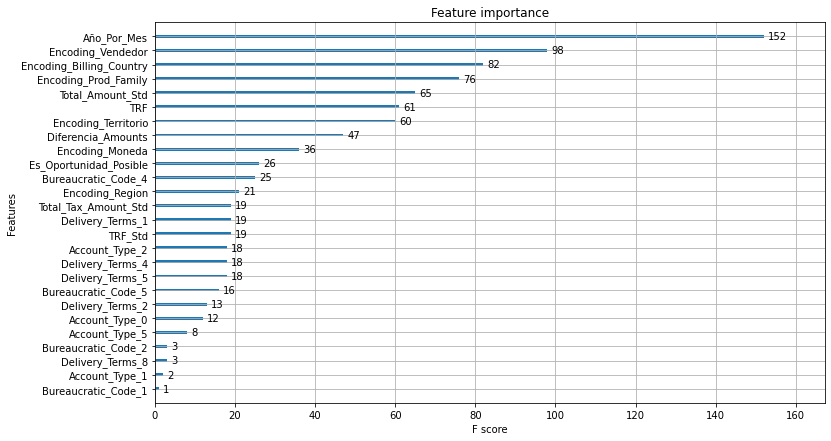

In [252]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

In [253]:
division_x_test = division_x_test.reset_index()
serie1 = pd.DataFrame(division_x_test['Opportunity_ID'])
serie2 = pd.DataFrame(promedio)
serie3 = pd.DataFrame(division_y_test)
serie3 = serie3.reset_index()
df_datos = pd.DataFrame(serie1)
df_datos['Target'] = serie2
df_datos.columns = ['Opportunity_ID', 'Target']
df_datos['Prediccion'] = df_datos['Target'].round()

In [254]:
df_datos = df_datos.merge(serie3,on='Opportunity_ID')
acertados = df_datos[df_datos['Prediccion'] == df_datos['Stage']]
errados = df_datos[df_datos['Prediccion'] != df_datos['Stage']]

In [255]:
acertados

,Opportunity_ID,Target,Prediccion,Stage
1,9084,0.850252,1.0,1
2,7527,0.764277,1.0,1
3,7080,0.394468,0.0,0
4,2137,0.587244,1.0,1
5,7750,0.590749,1.0,1
...,...,...,...,...
2083,4126,0.281882,0.0,0
2084,6722,0.304923,0.0,0
2085,2551,0.257676,0.0,0
2086,7127,0.436436,0.0,0


In [256]:
errados

,Opportunity_ID,Target,Prediccion,Stage
0,2383,0.565588,1.0,0
9,8169,0.737417,1.0,0
16,4048,0.537628,1.0,0
17,1489,0.322022,0.0,1
33,4660,0.373365,0.0,1
...,...,...,...,...
2060,5541,0.789524,1.0,0
2062,2696,0.224477,0.0,1
2063,12391,0.556203,1.0,0
2074,9447,0.453683,0.0,1
